# Moneta truccata

Si vuole valutare se una moneta è truccata. L'ipotesi nulla $\text{H}_0$ da falsificare è "la moneta non è truccata". Si sceglie come statistica test la percentuale di risultati "testa" sul numero di lanci.

L'esperimento viene condotto per un numero incrementale di esperimenti.

## Import librerie e funzioni utili

### Import librerie
Reset delle variabili e import librerie.

In [1]:
%reset -f

# Import libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Funzione per lo svolgimento di un esperimento
La funzione per lo svolgimento di un esperimento qui definita prende come argomenti un generatore di numeri casuali e i suoi parametri, e restituisce i campioni prodotti secondo la distribuzione data. Vengono definiti dei parametri di default, corrispondenti a una distribuzione di Bernoulli uniforme

In [2]:
#> Random process of interest, unknown execpt for the sample.
p_head_default = .5
p_tail_default = 1. - p_head_default

# Coin flip as a Bernoulli probability with outcomes: a = [0, 1] with prob p = [p_head, p_tail]
flip_rng_default = np.random.default_rng(42).choice
flip_params_default = { 'a': [0,1], 'p': [p_head_default, p_tail_default], 'size': 1 }   # default params

def run_experiment(rng=flip_rng_default, rng_params=flip_params_default):
    return rng(**rng_params)

### Funzione che restituisce la pdf $p(x|\text{H}_0)$

In [3]:
# ! Approach for low-dimensional problems, with no memory or performance issues

#> Null hypotesis, H0: the coin is fair
# # The outcome of a single flip is a r.v. distributed like a Bernoulli variable with p_head = .5
# # Every flip is statistically independent from the other
# ixv= np.arange(n_flips+1)
# xv = ixv / n_flips
# 
# #> Test statistics: average n.of heads in flip_n samples
# # H0 hypotesis implies that the outcome of flip_n is a r.v. with Binomial pdf
# x_H0_fv = sp.stats.binom.pmf(ixv, n_flips, p_head)


def px_H0(p, p_params,):
    return p(**p_params)
    

### Funzioni per la ricerca degli intervalli di accettazione dell'ipotesi
Vengono qui definite due funzoni per la ricerca degli intervalli di accettazione, dato il livello di significatività del test richiesto. La prima funzione ricerca un unico intervallo di accettazione riferito a un unico livello di significatività; la seconda funzione ricerca tanti intervalli di accettazione quanti sono i livelli di significatività cercati: ad esempio, si possono cercare simultaneamente i livellidi significatività associati a $\sigma$, $2 \sigma$, $3 \sigma$...

In [4]:
#> Acceptance and rejection regions, for discrete pdf
# Starting from the value of the test statistics x_max = max(x_H0_fv), expand 

def find_acceptance_region(p, alpha, test_type='value'):
    """
    Find acceptance region for a discrete pdf, supposed to be unimodal 
    for a given value of significance level
    
    test_type is not used so far...
    """
    x_max = np.argmax(p)
    nx = len(p)
    threshold = 1. - alpha

    # Initialization
    p_acc, xl, xr = p[x_max], x_max, x_max
    
    # if ( test_type == 'value' ):
    while ( p_acc < threshold ):
        if ( p[xl-1] >= p[xr+1] ):
            xl -= 1;  p_acc += p[xl]
        else:
            xr += 1;  p_acc += p[xr]

    # else:
    return xl, xr


def find_acceptance_regions(p, alpha_v, test_type='value'):
    """
    Find acceptance region for a discrete pdf, supposed to be unimodal 
    for a set of values of significance levels, type(alpha_v) = numpy.array

    test_type is not used so far...
    """
    #> Dimensions
    ix_max = np.argmax(p)
    nx, nal = len(p), len(alpha_v)
    ixlv, ixrv = np.zeros(nal), np.zeros(nal)

    #> Sorting
    alpha_v = np.sort(alpha_v)[::-1]
    threshold_v = 1. - alpha_v

    # Initialization
    p_acc, ixl, ixr = p[ix_max], ix_max, ix_max

    #> Loop over all the thresholds
    for ial in np.arange(nal):        
        while ( p_acc < threshold_v[ial] ):
            if ( p[ixl-1] > p[ixr+1] ):
                ixl -= 1;  p_acc += p[ixl]
            else:
                ixr += 1;  p_acc += p[ixr]
                
        ixlv[ial], ixrv[ial] = ixl, ixr
        

    return ixlv, ixrv

#> Test
# n_flips = 160
# x_H0_fv = sp.stats.binom.pmf(np.arange(n_flips+1), n_flips, .5)   # p_fair_coin .5
# xlv, xrv = find_acceptance_regions(x_H0_fv, alpha_v,)
# print(xlv, xrv)


## Esperimento

### Livelli di accettazione

In [5]:
#> Test characteristics: symmetric
test_type = 'value'  # 'symmetric', 'right', 'left', 'value'

#> Significance level, alpha = .05 ("default")
alpha = .05
alpha_v = np.array([ .3, .05, .003 ])

### Svolgimento esperimento
L'esperimento viene svolto usando due monete, la cui natura è a priori incognita, che possono essere modellate con variabili casuali di Bernoulli: una moneta non truccata produce testa o croce con la probaiblità uniforme $0.5$; una moneta truccata che produce testa o croce con probabilità $0.45 - 0.55$

In [6]:


#> Run experiments, with incremental number of samples
n_flips_1 = 20
n_flips_max = 5000

n_flips = 0
H0_true = True
ov_fair, ov_rigg = [], []
xlv, xrv, xsv_fair, xsv_rigg, n_flipsv = [], [], [], [], []

flip_rng = np.random.default_rng().choice
flip_params_fair = { 'a': [0,1], 'p': [.5 , .5 ], 'size': n_flips_1 }   # default params
flip_params_rigg = { 'a': [0,1], 'p': [.45, .55], 'size': n_flips_1 }   # default params

while ( n_flips < n_flips_max and H0_true ):
    
    #> Run a new experiment and collect new n_flips_1 samples
    n_flips += n_flips_1
    ov_fair_1 = run_experiment(rng=flip_rng, rng_params=flip_params_fair)
    ov_rigg_1 = run_experiment(rng=flip_rng, rng_params=flip_params_rigg)
    ov_fair += list(ov_fair_1)
    ov_rigg += list(ov_rigg_1)
    
    #> Find distribution function
    x_H0_fv = px_H0(sp.stats.binom.pmf, {'k': np.arange(0,n_flips+1), 'n': n_flips, 'p': .5})  # H0: fair coin

    #> Evaluate acceptance region
    ixl, ixr = find_acceptance_regions(x_H0_fv, alpha_v,)
    # print(n_flips, ixl, ixr)

    #> Evaluate test statistics on the sample
    ixs_fair = np.sum(ov_fair)
    ixs_rigg = np.sum(ov_rigg)

    #> Check if H0 is not false. If commented, let the while run until n_flips = n_flips_max
    # if ( ixl[-1] > ix_s or ixr[-1] < ix_s ):
    #     H0_true = False

    #> Store quantities for plots
    n_flipsv += [ n_flips ]
    xlv += [ ixl/n_flips ]
    xrv += [ ixr/n_flips ]
    xsv_fair += [ ixs_fair/n_flips ]
    xsv_rigg += [ ixs_rigg/n_flips ]



/home/davide/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


### Grafici
Il valore medio delle volte che è uscita croce viene usata come statistica test. Il valore della statistica test per gli esperimenti condotti con le due monete viene confrontato con la funzione di distribuzione $p(x|\text{H}_0)$ per una moneta non truccata. Viene mostrato l'andamento delle statistiche test e degli intervalli di accettazione in funzione del numero di lanci della moneta. Vengono mostrati i dati raccolti e successivamente depurati della media attesa e scalati per la varianza della media campionaria $\frac{\sigma}{\sqrt{n_s}}$, per mettere in evidenza i livelli di significatività $[0.3, 0.05, 0.003]$

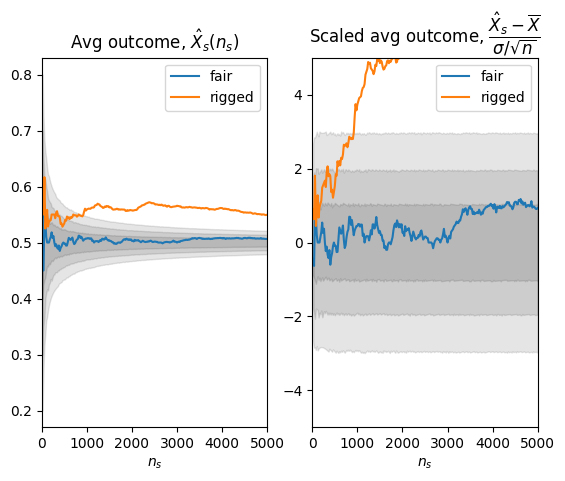

In [7]:
#> Convert list to numpy arrays, to perform some algebra below
n_flipsv = np.array(n_flipsv)
xlv = np.array(xlv)
xrv = np.array(xrv)
xsv_fair = np.array(xsv_fair)
xsv_rigg = np.array(xsv_rigg)

#> 
plt.figure()
plt.subplot(1,2,1)
for ial in np.arange(len(alpha_v)):
    # plt.plot(n_flipsv, xlv[:,ial], color=plt.cm.tab10(ial))
    # plt.plot(n_flipsv, xrv[:,ial], color=plt.cm.tab10(ial))
    plt.fill_between(n_flipsv, 
                     xlv[:,ial], 
                     xrv[:,ial], color=(0,0,0,.1))
plt.plot(n_flipsv, xsv_fair, color=plt.cm.tab10(0), label='fair')
plt.plot(n_flipsv, xsv_rigg, color=plt.cm.tab10(1), label='rigged')
plt.xlim(0, n_flips)
#plt.ylim(-5, 5)
plt.title("Avg outcome, $\hat{X}_s(n_s)$")
plt.xlabel('$n_s$')
plt.legend()

#> For scaling results
bernoulli_avg, bernoulli_var = .5, .25

plt.subplot(1,2,2)
for ial in np.arange(len(alpha_v)):
    # plt.plot(n_flipsv, xlv[:,ial], color=plt.cm.tab10(ial))
    # plt.plot(n_flipsv, xrv[:,ial], color=plt.cm.tab10(ial))
    plt.fill_between(n_flipsv, 
                     (xlv[:,ial]-bernoulli_avg) * n_flipsv**.5/bernoulli_var**.5, 
                     (xrv[:,ial]-bernoulli_avg) * n_flipsv**.5/bernoulli_var**.5, color=(0,0,0,.1))
plt.plot(n_flipsv, (xsv_fair-bernoulli_avg) * n_flipsv**.5/bernoulli_var**.5, color=plt.cm.tab10(0), label='fair')
plt.plot(n_flipsv, (xsv_rigg-bernoulli_avg) * n_flipsv**.5/bernoulli_var**.5, color=plt.cm.tab10(1), label='rigged')
plt.xlim(0, n_flips)
plt.ylim(-5, 5)
plt.title("Scaled avg outcome, $\dfrac{\hat{X}_s - \overline{X}}{\sigma/\sqrt{n}}$")
plt.xlabel('$n_s$')
plt.legend()